In [6]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from enm.utils import *

# Giant component size change

In [2]:
cpcc = pd.read_csv('../data/interim/costanzo_pcc_ALL')

In [22]:
def get_giant_component(G):
    Gc = max([G.subgraph(c).copy() for c in nx.connected_components(G)], key=len)
    return Gc

In [355]:
ne_ratio_list = []
nv_ratio_list = []

In [9]:
thr_list =  [0.05,0.1,0.2,0.25,0.3,0.35,0.4]

In [357]:
for i in np.arange(0.2,0.75,0.05):
    df = cpcc.loc[cpcc.pcc>=i]
    nw = nx.from_pandas_edgelist(df,source='gene1',target='gene2')
    nw_g = get_giant_component(nw)
    n_e = len(nw_g.edges)
    ne_ratio_list.append(n_e/len(nw.edges))
    n_v = len(nw_g.nodes)
    nv_ratio_list.append(n_v/len(nw.nodes))

    print(f"{i} : ne = {n_e}, ne_ratio: {n_e/len(nw.edges)}, nv = {n_v}, nv_ratio = {n_v/len(nw.nodes)}")

0.2 : ne = 39816, ne_ratio: 0.9987457984247228, nv = 5183, nv_ratio = 0.9831183611532626
0.25 : ne = 20810, ne_ratio: 0.9893505752591043, nv = 3924, nv_ratio = 0.932287954383464
0.3 : ne = 10973, ne_ratio: 0.9426166136929817, nv = 2615, nv_ratio = 0.7960426179604262
0.35 : ne = 5857, ne_ratio: 0.8150570553854718, nv = 1686, nv_ratio = 0.646968534151957
0.39999999999999997 : ne = 862, ne_ratio: 0.21034651049292338, nv = 280, nv_ratio = 0.1423487544483986
0.44999999999999996 : ne = 246, ne_ratio: 0.10967454302273741, nv = 105, nv_ratio = 0.07553956834532374
0.49999999999999994 : ne = 93, ne_ratio: 0.07795473595976529, nv = 57, nv_ratio = 0.06168831168831169
0.5499999999999999 : ne = 26, ne_ratio: 0.044905008635578586, nv = 18, nv_ratio = 0.03180212014134275
0.5999999999999999 : ne = 20, ne_ratio: 0.07662835249042145, nv = 9, nv_ratio = 0.030303030303030304
0.6499999999999999 : ne = 10, ne_ratio: 0.08333333333333333, nv = 6, nv_ratio = 0.0379746835443038
0.7 : ne = 6, ne_ratio: 0.12, nv =

In [358]:
xlab = "Pearson's Correlation Coefficient threshold"

Text(0.5, 0, "Pearson's Correlation Coefficient threshold")

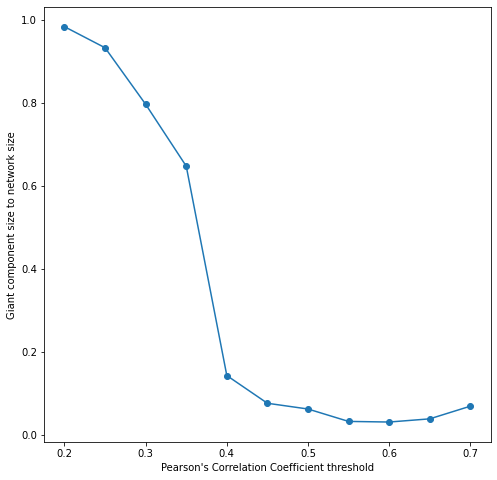

In [359]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.plot(np.arange(0.2,0.75,0.05),nv_ratio_list,'o-')
ax.set_ylabel('Giant component size to network size')
ax.set_xlabel(xlab)

# Effector and sensor clusters with GO enrichments

In [7]:
sensor_df_names = [ ]

In [10]:
effector_dfs = get_result_dfs('effectors_df', thr_list)

In [11]:
sensor_dfs =  get_result_dfs('sensors_df', thr_list)

In [12]:
effector_sensor_go_dfs = get_result_dfs('effector_sensor_combined_go_df',thr_list)

In [294]:
sensor_dfs[0.2].dropna(subset=['sensor_cluster']).loc[:,'sensor_cluster'].nunique()

9

In [38]:
def plot_go_thr_comparison(dfs, col, yaxis,plotname, xlab='PCC Threshold'):
    n_goterms = []
    rat_goterms = []
    n_clusters = []
    n_go_clusters = []
    for i in thr_list:
        df = dfs[i]
        n_goterms.append(df.dropna(subset=['go_group']).shape[0])
        rat_goterms.append(n_goterms[-1]/df.shape[0])
        n_clusters.append(df.dropna(subset=[col]).loc[:,col].nunique())
        n_go_clusters.append(df.dropna(subset=[col]).loc[:,'go_group'].nunique())
        
    fig, axs = plt.subplots(1,2,figsize=(5,2.5))
    axs[0].plot(thr_list, n_clusters, 'o-')
    axs[0].set_ylabel(f'Number of {yaxis} clusters', fontsize=12)
    axs[0].set_xlabel(xlab, fontsize=12)
    
    axs[1].plot(thr_list, n_go_clusters, 'o-')
    axs[1].set_ylabel(f'Number of go enriched\n{yaxis} clusters', fontsize=12)
    axs[1].set_xlabel(xlab, fontsize=12)
    
    plt.tight_layout()
    fig.savefig(f'../reports/figures/paper_figures_supp/{plotname}.png', bbox_inches='tight', dpi=150)
    # axs[2].plot(thr_list, [i/j if i!=0 else 0 for i,j in zip(n_go_clusters,n_clusters) ], 'o-')
    # axs[2].set_ylabel(f'% of go enriched {yaxis} clusters')
    # axs[2].set_xlabel(xlab)

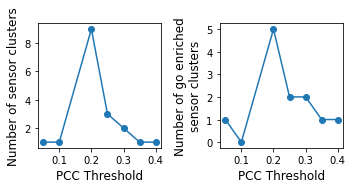

In [39]:
plot_go_thr_comparison(sensor_dfs,'sensor_cluster', 'sensor',plotname='thr_num_sensor_clusters')

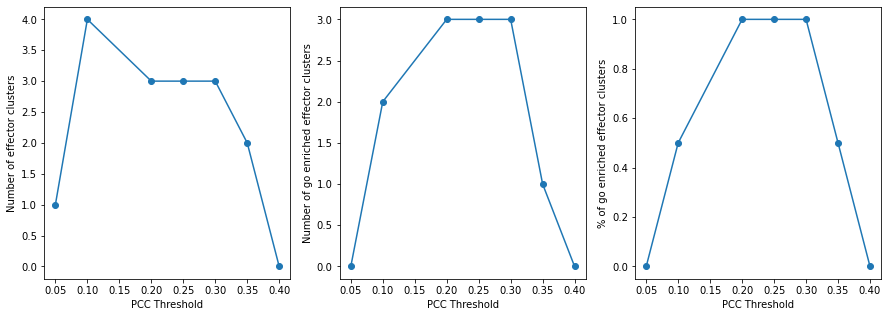

In [19]:
plot_go_thr_comparison(effector_dfs,'effector_cluster', 'effector')

In [35]:
effector_sensor_go_dfs[0.2]

,GO,NS,enrichment,name,ratio_in_study,ratio_in_pop,p_uncorrected,depth,study_count,p_fdr,study_items,cluster_id,cluster_type
0,GO:0010106,BP,e,cellular response to iron ion starvation,"(2, 3)","(6, 5672)",0.000003,7,2,0.002,"['YMR058W', 'YGL071W']",8.0,sensor
1,GO:0006826,BP,e,iron ion transport,"(2, 3)","(37, 5672)",0.000124,7,2,0.042,"['YMR058W', 'YGL071W']",8.0,sensor
2,GO:0006879,BP,e,cellular iron ion homeostasis,"(2, 3)","(43, 5672)",0.000168,10,2,0.048,"['YMR058W', 'YGL071W']",8.0,sensor
3,GO:0055072,BP,e,iron ion homeostasis,"(2, 3)","(51, 5672)",0.000236,9,2,0.052,"['YMR058W', 'YGL071W']",8.0,sensor
4,GO:0009267,BP,e,cellular response to starvation,"(2, 3)","(58, 5672)",0.000306,6,2,0.056,"['YMR058W', 'YGL071W']",8.0,sensor
...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,GO:0004175,MF,e,endopeptidase activity,"(4, 20)","(76, 5672)",0.000123,4,4,0.036,"['YLR459W', 'YDR434W', 'YDR331W', 'YHR188C']",1.0,effector
226,GO:0016758,MF,e,hexosyltransferase activity,"(4, 20)","(80, 5672)",0.000150,4,4,0.036,"['YOR085W', 'YOR336W', 'YEL002C', 'YGL142C']",1.0,effector
227,GO:0004576,MF,e,oligosaccharyl transferase activity,"(2, 20)","(7, 5672)",0.000245,5,2,0.046,"['YOR085W', 'YEL002C']",1.0,effector
228,GO:0004579,MF,e,dolichyl-diphosphooligosaccharide-protein glyc...,"(2, 20)","(7, 5672)",0.000245,6,2,0.046,"['YOR085W', 'YEL002C']",1.0,effector


In [32]:
help(t.set_text)

NameError: name 't' is not defined

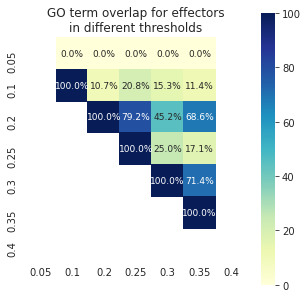

In [57]:
#effector_sensor_go_dfs
go_overlap = pd.DataFrame({thr : [len(np.intersect1d(effector_sensor_go_dfs[thr].loc[effector_sensor_go_dfs[thr].cluster_type=='effector','GO'], effector_sensor_go_dfs[i].loc[effector_sensor_go_dfs[i].cluster_type=='effector','GO'])) for i in thr_list] for thr in sorted(thr_list)})
go_overlap.index = thr_list
def plot_heatmap_overlap(df, filename, title , cmap='YlGnBu' , figsize = (10,6)):
    import seaborn as sns
    mask = np.zeros_like(df)
    mask[np.tril_indices_from(mask, k=-1)] = True
    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(100*df/ np.diag(df),annot=True, mask= mask, square=True, vmax=100, cbar=True, ax=ax, fmt='.1f',cmap=cmap)
        ax.set_title(title)
        
        for t in ax.texts: 
            t.set_text(t.get_text() + "%")
            t.set_size(9)
        ax.set_xlabel(ax.get_xlabel(),fontsize=16)
    plt.savefig(f'../reports/figures/paper_figures_supp/{filename}.png', bbox_inches='tight',dpi=150)    

plot_heatmap_overlap(go_overlap, 'go_overlap_test', 'GO term overlap for effectors\nin different thresholds', figsize=(5,5))

In [58]:

sensor_overlap = pd.DataFrame({thr : [len(np.intersect1d(sensor_dfs[thr].orf_name, sensor_dfs[i].orf_name)) for i in thr_list] for thr in sorted(thr_list)})
sensor_overlap.index = thr_list

effector_overlap = pd.DataFrame({thr : [len(np.intersect1d(effector_dfs[thr].orf_name, effector_dfs[i].orf_name)) for i in thr_list] for thr in sorted(thr_list)})
effector_overlap.index = thr_list

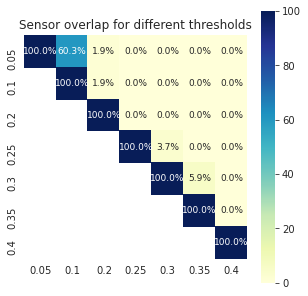

In [59]:
plot_heatmap_overlap(sensor_overlap, 'sensor_overlap', 'Sensor overlap for different thresholds', figsize=(5,5))

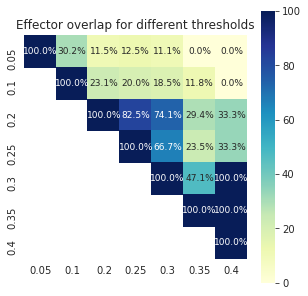

In [54]:
plot_heatmap_overlap(effector_overlap, 'effector_overlap', 'Effector overlap for different thresholds', figsize=(5,5))

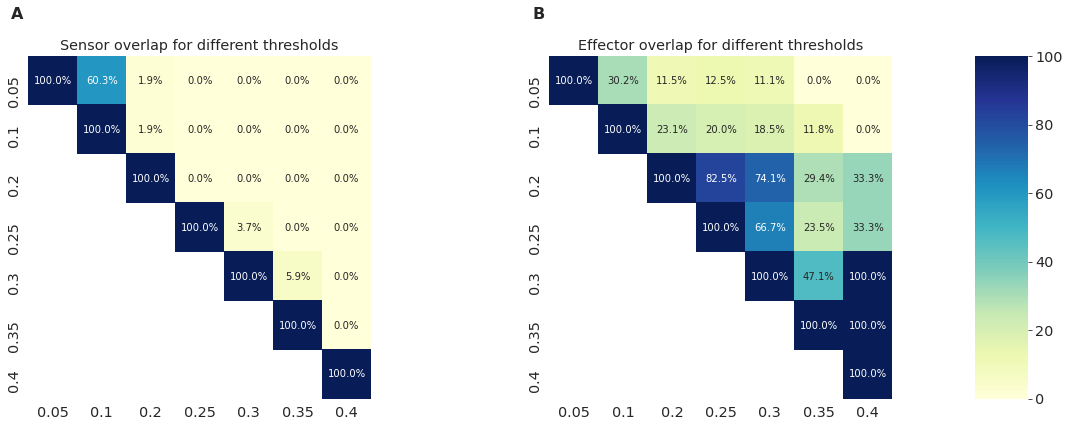

In [655]:

sensor_overlap = pd.DataFrame({thr : [len(np.intersect1d(sensor_dfs[thr].orf_name, sensor_dfs[i].orf_name)) for i in thr_list] for thr in sorted(thr_list)})
sensor_overlap.index = thr_list

effector_overlap = pd.DataFrame({thr : [len(np.intersect1d(effector_dfs[thr].orf_name, effector_dfs[i].orf_name)) for i in thr_list] for thr in sorted(thr_list)})
effector_overlap.index = thr_list

mask1 = np.zeros_like(sensor_overlap)
mask1[np.tril_indices_from(mask1, k=-1)] = True
mask2 = np.zeros_like(effector_overlap)
mask2[np.tril_indices_from(mask2,k=-1)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(1,3,figsize=(16, 6), gridspec_kw={'width_ratios': [10,10, 1]})
    ax[0] = sns.heatmap(100*sensor_overlap / np.diag(sensor_overlap),annot=True, mask=mask1, square=True, vmax=100, cbar=False, ax=ax[0], fmt='.1f',cmap="YlGnBu")
    ax[0].set_title('Sensor overlap for different thresholds')
    for t in ax[0].texts: t.set_text(t.get_text() + "%")
    ax[1] = sns.heatmap(100 * effector_overlap / np.diag(effector_overlap),annot=True, mask=mask2, square=True, ax=ax[1],cbar_ax=ax[2], vmax=100, fmt='.1f',cmap="YlGnBu")
    for t in ax[1].texts: t.set_text(t.get_text() + "%")
    ax[1].set_title('Effector overlap for different thresholds')
    ax[0].text(-0.1, -1, 'A', fontsize=16, fontweight='bold',va='top',ha='right')
    ax[1].text(-0.1, -1, 'B', fontsize=16, fontweight='bold',va='top',ha='right')


plt.tight_layout()
plt.savefig('../reports/figures/paper_figures_supp/figs3.png', bbox_inches='tight',dpi=150)

In [175]:
import itertools as itr

In [218]:
def get_pairwise_intersect(dfs, thr_list):
    pairs = itr.combinations(thr_list,2)
    nt = lambda a, b: [len(np.intersect1d(dfs[a].orf_name,effector_dfs[b].orf_name)) , len(dfs[b].orf_name)]
    res = dict([ (t, nt(*t)) for t in pairs ])

    return res

In [220]:
get_pairwise_intersect(effector_dfs, thr_list)

{(0.2, 0.25): [33, 40],
 (0.2, 0.3): [20, 27],
 (0.2, 0.35): [5, 17],
 (0.2, 0.4): [1, 3],
 (0.2, 0.45): [1, 2],
 (0.2, 0.5): [1, 1],
 (0.25, 0.3): [18, 27],
 (0.25, 0.35): [4, 17],
 (0.25, 0.4): [1, 3],
 (0.25, 0.45): [1, 2],
 (0.25, 0.5): [1, 1],
 (0.3, 0.35): [8, 17],
 (0.3, 0.4): [3, 3],
 (0.3, 0.45): [2, 2],
 (0.3, 0.5): [1, 1],
 (0.35, 0.4): [3, 3],
 (0.35, 0.45): [2, 2],
 (0.35, 0.5): [0, 1],
 (0.4, 0.45): [2, 2],
 (0.4, 0.5): [0, 1],
 (0.45, 0.5): [0, 1]}

In [221]:
get_pairwise_intersect(sensor_dfs, thr_list)

{(0.2, 0.25): [0, 40],
 (0.2, 0.3): [0, 27],
 (0.2, 0.35): [0, 17],
 (0.2, 0.4): [0, 3],
 (0.2, 0.45): [0, 1],
 (0.2, 0.5): [0, 1],
 (0.25, 0.3): [0, 27],
 (0.25, 0.35): [0, 17],
 (0.25, 0.4): [0, 3],
 (0.25, 0.45): [0, 1],
 (0.25, 0.5): [0, 1],
 (0.3, 0.35): [0, 17],
 (0.3, 0.4): [0, 3],
 (0.3, 0.45): [0, 1],
 (0.3, 0.5): [0, 1],
 (0.35, 0.4): [0, 3],
 (0.35, 0.45): [0, 1],
 (0.35, 0.5): [0, 1],
 (0.4, 0.45): [0, 1],
 (0.4, 0.5): [0, 1],
 (0.45, 0.5): [0, 1]}

In [308]:
pcc_dfs = get_result_dfs('pcc_df', thr_list,0.2)

In [233]:
pcc_dfs[i].corr().loc['deg','eff']

0.9203905376819284

In [236]:
[pcc_dfs[i].corr('pearson').loc['deg','sens'] for i in thr_list]

[0.13913489431379195,
 0.1224190391634265,
 0.3374750698590764,
 0.1836172611995399,
 -0.08122530817819895,
 -0.23685738216798707,
 -0.07267183919021618]

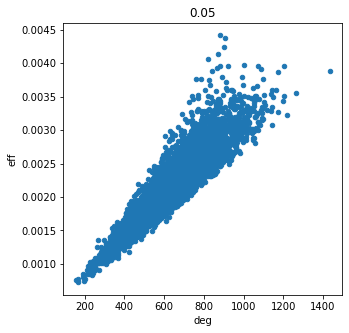

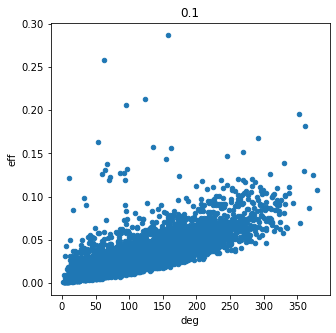

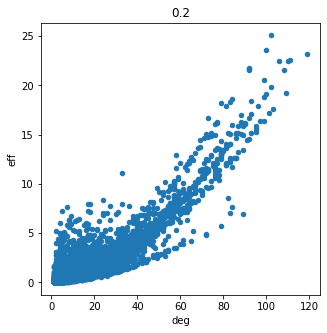

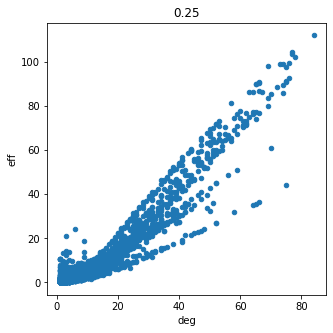

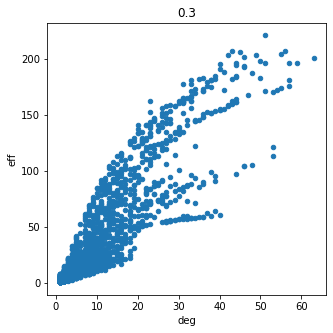

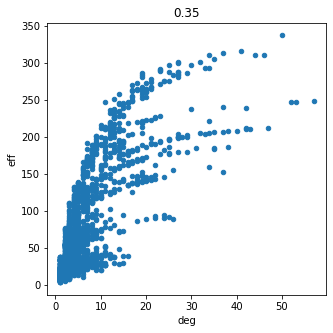

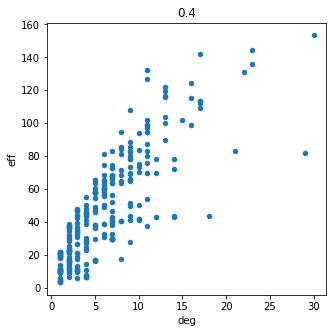

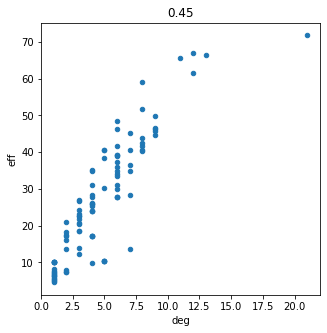

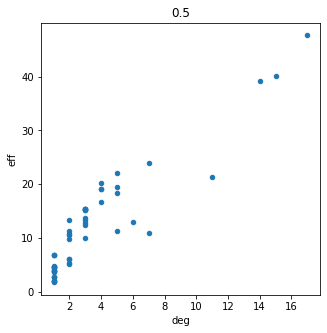

In [312]:
for i in thr_list:
    fig, ax = plt.subplots(figsize=(5,5))
    pcc_dfs[i].plot.scatter('deg','eff',ax=ax)
    ax.set_title(i)

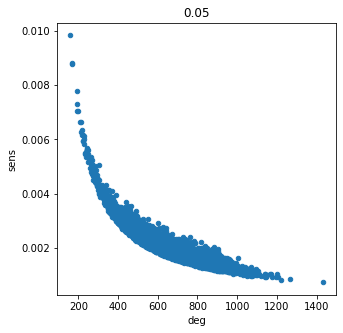

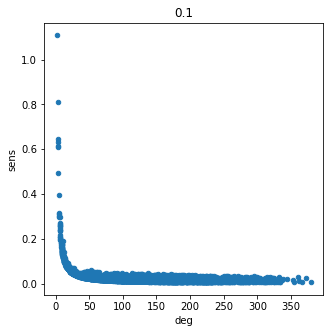

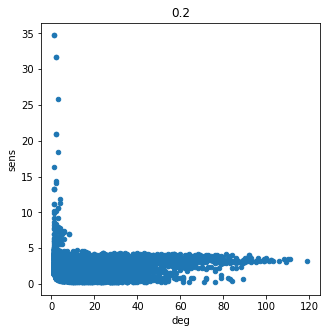

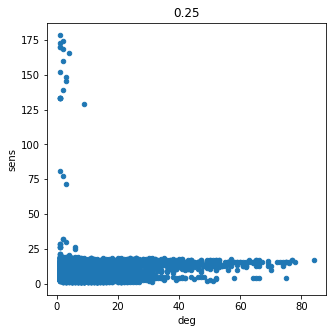

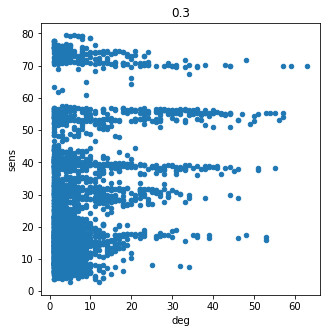

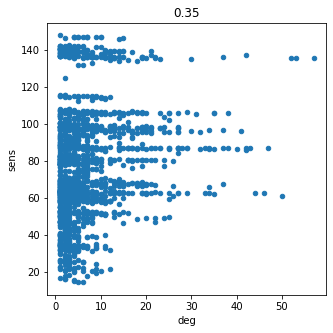

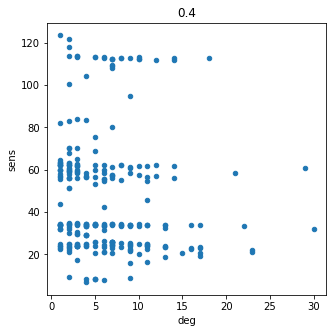

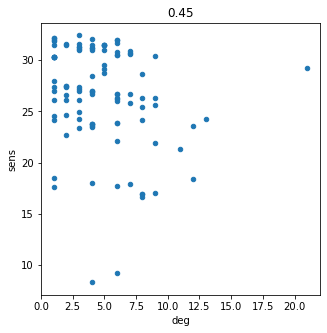

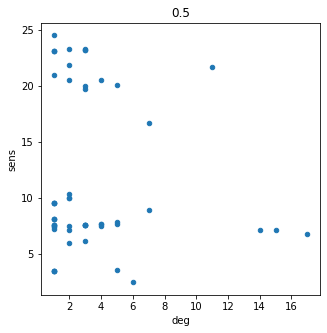

In [313]:
for i in thr_list:
    fig, ax = plt.subplots(figsize=(5,5))
    pcc_dfs[i].plot.scatter('deg','sens',ax=ax)
    ax.set_title(i)

In [159]:
sensor_dfs[0.3]

,orf_name,deg,eff,sens,trans,eigenvec_centr,closeness_centr,smallest_eigenvec,neighbor_degree,gene1,Systematic gene name,sensor_cluster,go_group
0,cem1,8,19.024903,78.248422,0.750000,7.988143e-11,0.113984,-0.002448,8.625000,cem1,YER061C,1.0,fatty acid metabolic process
1,aim22,10,19.812154,78.439643,0.622222,8.017645e-11,0.113994,-0.002453,7.700000,aim22,YJL046W,1.0,fatty acid metabolic process
2,etr1,7,15.270061,79.220229,0.809524,7.782998e-12,0.102357,-0.002468,7.857143,etr1,YBR026C,1.0,fatty acid metabolic process
3,htd2,8,16.001813,79.218922,0.821429,8.004045e-12,0.102361,-0.002468,7.625000,htd2,YHR067W,1.0,fatty acid metabolic process
4,lip2,10,19.812154,78.439643,0.622222,8.017645e-11,0.113994,-0.002453,7.700000,lip2,YLR239C,1.0,fatty acid metabolic process
5,lip5,8,16.001813,79.218922,0.821429,8.004042e-12,0.102361,-0.002468,7.625000,lip5,YOR196C,1.0,fatty acid metabolic process
6,lpd1,4,11.344847,79.383812,0.833333,5.021902e-12,0.102345,-0.002473,8.250000,lpd1,YFL018C,1.0,fatty acid metabolic process
7,lpd1-supp1,5,13.286361,79.167241,1.000000,7.412230e-12,0.102349,-0.002467,8.800000,lpd1-supp1,YFL018C,1.0,fatty acid metabolic process
8,mct1,7,15.259172,79.223154,0.904762,7.795662e-12,0.102357,-0.002468,8.142857,mct1,YOR221C,1.0,fatty acid metabolic process
9,oar1,6,13.971691,79.367389,0.800000,5.472296e-12,0.102353,-0.002471,7.833333,oar1,YKL055C,1.0,fatty acid metabolic process


In [257]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns



# Sensor change in different thresholds

In [364]:
all_df = pd.read_csv('../data/raw/Data File S3. Genetic interaction profile similarity matrices/cc_ALL.txt','\t',index_col=[0,1], header=[0,1])

In [367]:
df_long_renamed = all_df.melt(ignore_index=False, col_level=0).reset_index(inplace=False).rename(columns = {'level_0':'gene1','level_1':'Systematic gene name', 'variable':'gene2','value':'pcc'})

In [405]:
print("PCC threshold","Sensors in the higher threshold network","Sensors in the higher threshold GC","Number of sensors")
for i in range(1,len(thr_list)):
    prev = thr_list[i-1]
    curr = thr_list[i]
    
    sensor_names = sensor_dfs[prev].orf_name
    all_edges = df_long_renamed.loc[(df_long_renamed.pcc>=curr)]
    all_nodes = np.unique([*all_edges.gene1, *all_edges.gene2])
    
    print(prev, sum(sensor_names.isin(all_nodes)), sum(sensor_names.isin(pcc_dfs[curr].orf_name)) , len(sensor_names))

PCC threshold Sensors in the higher threshold network Sensors in the higher threshold GC Number of sensors
0.05 63 63 63
0.1 9 5 63
0.2 28 3 52
0.25 12 1 40
0.3 21 19 27
0.35 15 0 17
0.4 1 0 3
0.45 1 0 1


0.05 0.06096 6230
0.1 0.109875 6230
0.2 0.23868 5272
0.25 0.26991 4209
0.3 0.35452 3285
0.35 0.39382 2606
0.4 0.43577 1967
0.45 0.48646999999999996 1390
0.5 0.50576 924


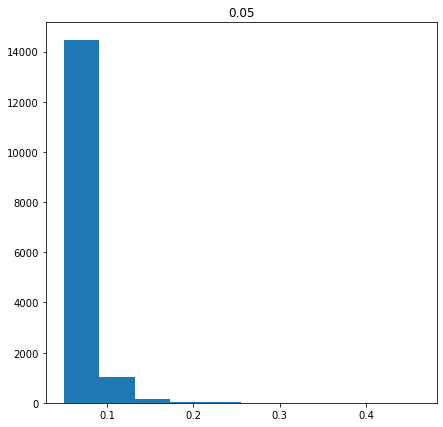

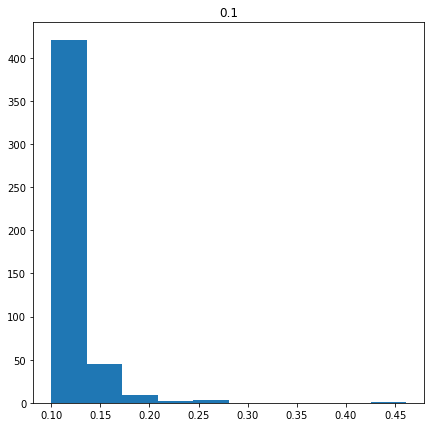

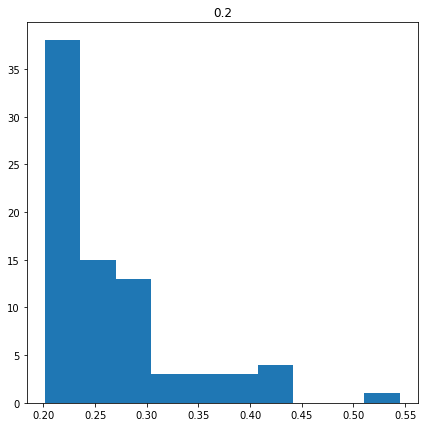

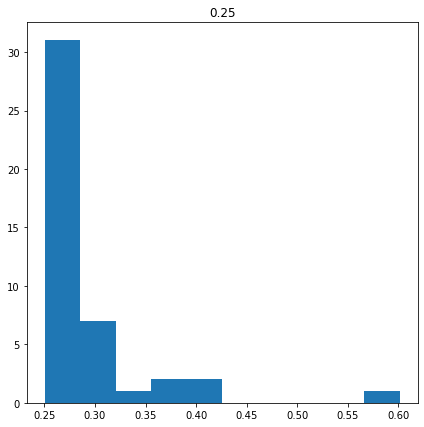

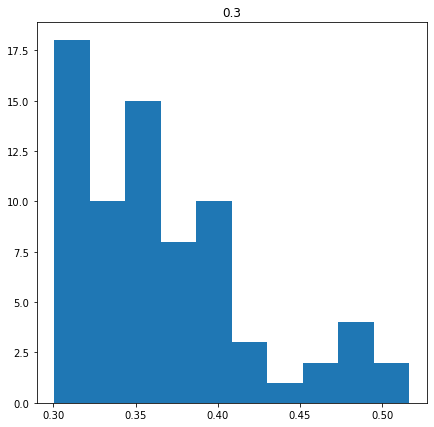

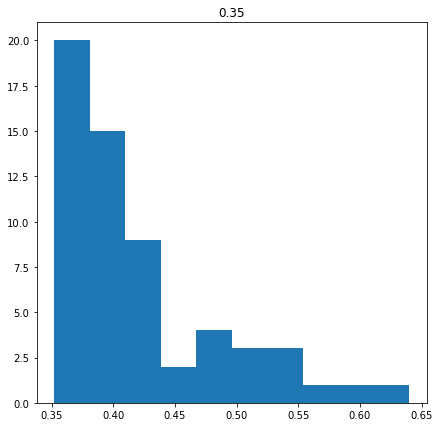

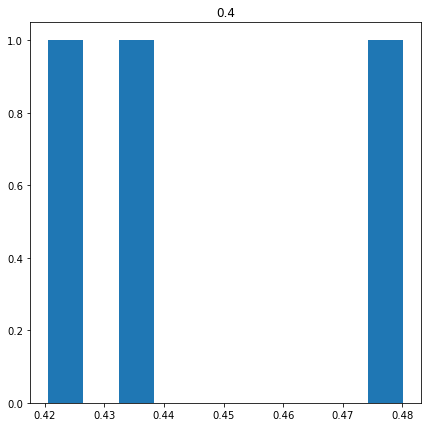

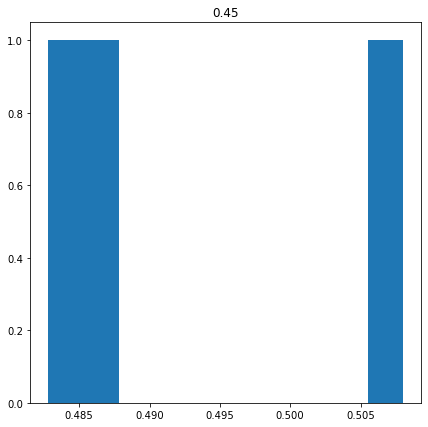

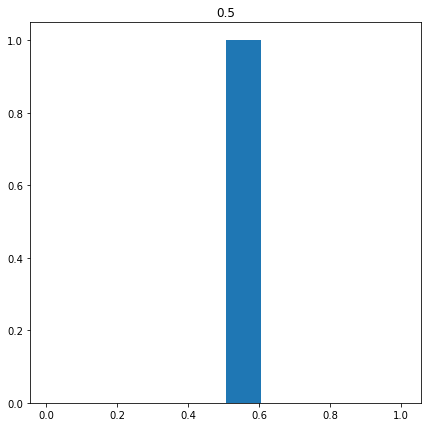

In [409]:
for i in thr_list:
    sensor_names = sensor_dfs[i].orf_name
    all_edges = df_long_renamed.loc[df_long_renamed.pcc>=i]
    g = nx.from_pandas_edgelist(all_edges,source='gene1',target='gene2',edge_attr='pcc')
    fig, ax = plt.subplots(figsize=(7,7))
    data = [val for u,v,val in g.edges(sensor_names.tolist(), data='pcc')]
    ax.hist(data)
    ax.set_title(i)
    print(i , np.median(data), len(g.nodes))

In [518]:
exn = pd.read_csv('../../pgsNetwork/analysis/data/derived_data/SGA_data_combined.csv','\t')

In [521]:
aa = exn.loc[exn['Query allele name'].isin(effector_dfs[0.2].orf_name) & exn['Array allele name'].isin(effector_dfs[0.2].orf_name) ]

In [527]:
exe_names = np.unique([*aa.loc[aa.data_source=='ExE']['Query allele name'],*aa.loc[aa.data_source=='ExE']['Array allele name']])
nxe_names = np.unique(aa.loc[aa.data_source=='ExN_NxE']['Array allele name'])

In [537]:
strain_ids = pd.read_csv('../../pgsNetwork/trymake/pgsNetwork//analysis/data/derived_data/strain_ids_with_experiment_count_all.csv')

In [538]:
strain_ids

,Systematic gene name,Allele Gene name,num,cat,maincat,bin
0,YAL002W,vps8,8910,na.nq.nxes,nonessential,90
1,YAL007C,erp2,8114,na.nq,nonessential,82
2,YAL008W,fun14,8158,na.nq,nonessential,82
3,YAL009W,spo7,4181,nq.nxes,nonessential,42
4,YAL010C,mdm10,8849,na.nq.nxes,nonessential,89
...,...,...,...,...,...,...
6013,YPR161C,sgv1-5001,3219,NaN,essential,33
6014,YPR183W,dpm1-6,3236,NaN,essential,33
6015,YAR019C,cdc15-2,3265,NaN,essential,33
6016,YAR007C,rfa1-m2,3299,NaN,essential,33


In [553]:
ii = 0.2
effector_dfs[ii].loc[effector_dfs[ii].orf_name.isin(strain_ids.loc[strain_ids.maincat=='essential']['Allele Gene name'])].shape[0]/effector_dfs[ii].shape[0]

0.28846153846153844